In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving cleaned_new.zip to cleaned_new.zip


In [ ]:
import zipfile, io
zip_path = list(uploaded.keys())[0]

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('cleaned_new')

In [ ]:
import os, math, time, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from PIL import Image
plt.switch_backend("agg")
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.metrics import classification_report, precision_recall_fscore_support

TRAIN_ROOT = "/content/cleaned/cleaned/Training"
TEST_ROOT  = "/content/cleaned/cleaned/Testing"
OUTDIR     = "/content"
SAVE_NAME  = "vit64_best.pt"

In [ ]:
EPOCHS       = 100
BATCH_SIZE   = 64
LR           = 3e-4
WEIGHT_DECAY = 1e-2
WORKERS      = 4
PATIENCE     = 10
SEED         = 0

class PatchEmbed(nn.Module):
    def __init__(self, in_ch=3, dim=128, patch=8):
        super().__init__()
        self.proj = nn.Conv2d(in_ch, dim, kernel_size=patch, stride=patch, bias=False)
    def forward(self, x):
        x = self.proj(x)
        x = x.flatten(2).transpose(1, 2)
        return x

class ViT64(nn.Module):

    def __init__(self, num_classes=4, img_size=64, patch=8, dim=192, depth=8, heads=6, mlp_ratio=4, drop=0.1, in_ch=3):
        super().__init__()
        assert img_size % patch == 0
        self.num_patches = (img_size // patch) ** 2
        self.dim = dim

        self.patch_embed = PatchEmbed(in_ch, dim, patch)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, dim))
        self.pos_embed = nn.Parameter(torch.randn(1, self.num_patches + 1, dim) * 0.02)
        self.pos_drop = nn.Dropout(drop)

        enc_layer = nn.TransformerEncoderLayer(
            d_model=dim, nhead=heads, dim_feedforward=dim * mlp_ratio,
            dropout=drop, batch_first=True, activation="gelu", norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=depth)
        self.norm = nn.LayerNorm(dim, eps=1e-6)
        self.head = nn.Linear(dim, num_classes)
        self.register_buffer("eps", torch.tensor(1e-6), persistent=False)

    def forward(self, x):
        x = self.patch_embed(x)
        B, N, _ = x.shape
        cls = self.cls_token.expand(B, 1, self.dim)
        x = torch.cat([cls, x], dim=1)
        x = x + self.pos_embed
        x = self.pos_drop(x)
        x = self.encoder(x)
        x = self.norm(x)
        return self.head(x[:, 0])

def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def make_transforms():
    train_tf = transforms.Compose([
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])
    val_tf = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5],
                             std=[0.5, 0.5, 0.5]),
    ])
    return train_tf, val_tf

def stratified_split_indices(targets, train_frac=0.8, seed=42):
    targets = np.array(targets)
    classes = np.unique(targets)
    rng = np.random.default_rng(seed)
    train_idx, val_idx = [], []
    for c in classes:
        idx = np.where(targets == c)[0]
        rng.shuffle(idx)
        n_train = int(round(len(idx) * train_frac))
        train_idx.extend(idx[:n_train])
        val_idx.extend(idx[n_train:])
    rng.shuffle(train_idx); rng.shuffle(val_idx)
    return train_idx, val_idx

def class_weights_from_indices(targets, idx):
    t = torch.tensor(np.array(targets)[idx])
    K = int(t.max().item() + 1)
    counts = torch.bincount(t, minlength=K).float()
    w = (counts.sum() / (counts + 1e-6))
    return (w / w.mean())

@torch.no_grad()
def evaluate(model, loader, device):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction="sum")
    loss_sum, correct, total = 0.0, 0, 0
    all_y, all_p = [], []
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += ce(logits, y).item()
        pred = logits.argmax(1)
        correct += (pred == y).sum().item()
        total += y.numel()
        all_y.append(y.cpu()); all_p.append(pred.cpu())
    y_true = torch.cat(all_y).numpy()
    y_pred = torch.cat(all_p).numpy()
    return loss_sum / total, correct / total, y_true, y_pred

@torch.no_grad()
def evaluate_with_probs(model, loader, device):
    model.eval()
    ce = nn.CrossEntropyLoss(reduction="sum")
    loss_sum, correct, total = 0.0, 0, 0
    all_y, all_p, all_logits = [], [], []

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss_sum += ce(logits, y).item()
        pred = logits.argmax(1)

        correct += (pred == y).sum().item()
        total   += y.numel()

        all_y.append(y.cpu())
        all_p.append(pred.cpu())
        all_logits.append(logits.cpu())

    y_true   = torch.cat(all_y).numpy()
    y_pred   = torch.cat(all_p).numpy()
    logits   = torch.cat(all_logits, dim=0)
    y_score  = F.softmax(logits, dim=1).numpy()

    return loss_sum / total, correct / total, y_true, y_pred, y_score

def plot_roc_curves(y_true, y_score, class_names, outpath):
    n_classes = len(class_names)

    y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

    fpr, tpr, roc_auc = {}, {}, {}

    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_bin.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    plt.figure(figsize=(6, 6))
    plt.plot(fpr["micro"], tpr["micro"], linestyle="--",
             label=f"micro-average (AUC = {roc_auc['micro']:.3f})")
    plt.plot(fpr["macro"], tpr["macro"], linestyle="--",
             label=f"macro-average (AUC = {roc_auc['macro']:.3f})")

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i],
                 label=f"{class_names[i]} (AUC = {roc_auc[i]:.3f})")

    plt.plot([0, 1], [0, 1], "k:", label="chance")

    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (one-vs-rest)")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.savefig(outpath)
    plt.close()

def plot_curves(history, outdir):
    outdir = Path(outdir); outdir.mkdir(parents=True, exist_ok=True)
    csv_path = outdir / "history.csv"
    with open(csv_path, "w", newline="") as f:
        wr = csv.writer(f); wr.writerow(["epoch","train_loss","train_acc","val_loss","val_acc"])
        for i in range(len(history["epoch"])):
            wr.writerow([history[k][i] for k in ["epoch","train_loss","train_acc","val_loss","val_acc"]])

    e = history["epoch"]
    plt.figure(figsize=(8,4))
    plt.plot(e, history["train_loss"], label="train")
    plt.plot(e, history["val_loss"],   label="val")
    plt.xlabel("epoch"); plt.ylabel("loss"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir/"loss.png"); plt.close()

    plt.figure(figsize=(8,4))
    plt.plot(e, history["train_acc"], label="train")
    plt.plot(e, history["val_acc"],   label="val")
    plt.xlabel("epoch"); plt.ylabel("accuracy"); plt.legend(); plt.tight_layout()
    plt.savefig(outdir/"acc.png"); plt.close()

def plot_confusion(y_true, y_pred, class_names, outpath):
    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(class_names))))
    cm = cm.astype(np.int32)
    plt.figure(figsize=(5,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title("Confusion Matrix")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha="right")
    plt.yticks(range(len(class_names)), class_names)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, str(cm[i, j]), ha="center", va="center")
    plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout()
    plt.savefig(outpath); plt.close()

set_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

train_tf, val_tf = make_transforms()

full_train = datasets.ImageFolder(TRAIN_ROOT, transform=train_tf)
test_ds    = datasets.ImageFolder(TEST_ROOT,  transform=val_tf)
classes = full_train.classes
print("Classes:", classes)

train_idx, val_idx = stratified_split_indices(full_train.targets, train_frac=0.8, seed=SEED)
train_ds = Subset(full_train, train_idx)
val_base = datasets.ImageFolder(TRAIN_ROOT, transform=val_tf)
val_ds = Subset(val_base, val_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=WORKERS, pin_memory=True)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=WORKERS, pin_memory=True)

model = ViT64(num_classes=len(classes), in_ch=3).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
opt = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
sched = torch.optim.lr_scheduler.CosineAnnealingLR(
    opt, T_max=EPOCHS, eta_min=1e-6
)

outdir = Path(OUTDIR); outdir.mkdir(parents=True, exist_ok=True)
ckpt_path = outdir / SAVE_NAME

best_val = math.inf
patience_ctr = 0
history = {"epoch":[], "train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[]}

scaler = torch.amp.GradScaler("cuda", enabled=(device.type == "cuda"))

for epoch in range(1, EPOCHS + 1):
    model.train()
    t0 = time.time()
    run_loss, run_correct, run_total = 0.0, 0, 0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad(set_to_none=True)
        with torch.amp.autocast("cuda", enabled=(device.type == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        run_loss += loss.item() * y.size(0)
        run_correct += (logits.argmax(1) == y).sum().item()
        run_total += y.size(0)

    train_loss = run_loss / run_total
    train_acc  = run_correct / run_total

    val_loss, val_acc, _, _ = evaluate(model, val_loader, device)
    sched.step()

    history["epoch"].append(epoch)
    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch:03d} | {time.time()-t0:5.1f}s | "
          f"train {train_loss:.4f}/{train_acc:.4f} | "
          f"val {val_loss:.4f}/{val_acc:.4f}")

    if val_loss + 1e-6 < best_val:
        best_val = val_loss
        patience_ctr = 0
        torch.save({"model": model.state_dict(), "classes": classes}, ckpt_path)
        print(f"  → saved best to {ckpt_path}")
    else:
        patience_ctr += 1
        if patience_ctr >= PATIENCE:
            print(f"Early stopping (best val loss {best_val:.4f})")
            break

plot_curves(history, outdir)

ckpt = torch.load(ckpt_path, map_location=device)
model.load_state_dict(ckpt["model"])

test_loss, test_acc, y_true, y_pred, y_score = evaluate_with_probs(model, test_loader, device)
print(f"TEST   loss {test_loss:.4f}  acc {test_acc:.4f}")

plot_confusion(y_true, y_pred, classes, outdir/"confusion_test.png")

plot_roc_curves(y_true, y_score, classes, outdir/"roc_test.png")

print(f"Saved confusion matrix to {outdir/'confusion_test.png'}")
print(f"Saved ROC curves to {outdir/'roc_test.png'}")
print(f"History CSV / curves saved to {outdir}")

report = classification_report(
    y_true,
    y_pred,
    target_names=classes,
    digits=4
)

print(report)

with open(outdir / "classification_report.txt", "w") as f:
    f.write(report)


Device: cuda
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 001 |   6.1s | train 1.2564/0.3998 | val 1.0659/0.5158
  → saved best to /content/vit64_best.pt
Epoch 002 |   4.8s | train 1.0785/0.5127 | val 1.0661/0.5587
Epoch 003 |   6.2s | train 1.0023/0.5580 | val 0.8381/0.6366
  → saved best to /content/vit64_best.pt
Epoch 004 |   5.0s | train 0.9645/0.5937 | val 0.7922/0.6708
  → saved best to /content/vit64_best.pt
Epoch 005 |   5.2s | train 0.9009/0.6416 | val 0.7289/0.6961
  → saved best to /content/vit64_best.pt
Epoch 006 |   7.0s | train 0.8668/0.6615 | val 0.6657/0.7338
  → saved best to /content/vit64_best.pt
Epoch 007 |   5.1s | train 0.8343/0.6838 | val 0.6766/0.7207
Epoch 008 |   6.4s | train 0.8180/0.6860 | val 0.6273/0.7434
  → saved best to /content/vit64_best.pt
Epoch 009 |   5.5s | train 0.8087/0.6982 | val 0.6312/0.7452
Epoch 010 |   6.1s | train 0.7641/0.7271 | val 0.5668/0.7811
  → saved best to /content/vit64_best.pt
Epoch 011 |   5.4s | train 0.7505/0.7274 | val 0.5697/0.7820
Epoch 012 |   5.1s | train 0.7456/0.7302 |

In [ ]:
from collections import Counter
import numpy as np

def count_split(dataset, class_names):
    targets = np.array(dataset.dataset.targets)[dataset.indices] if isinstance(dataset, Subset) else np.array(dataset.targets)
    counts = Counter(targets)
    return {class_names[i]: counts.get(i, 0) for i in range(len(class_names))}

print("Image counts per class:")
print("  Train:", count_split(train_ds, classes))
print("  Val:  ", count_split(val_ds, classes))
print("  Test: ", count_split(test_ds, classes))


Image counts per class:
  Train: {'glioma': 1057, 'meningioma': 1071, 'notumor': 1276, 'pituitary': 1166}
  Val:   {'glioma': 264, 'meningioma': 268, 'notumor': 319, 'pituitary': 291}
  Test:  {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 3,609,604
Trainable parameters: 3,609,604


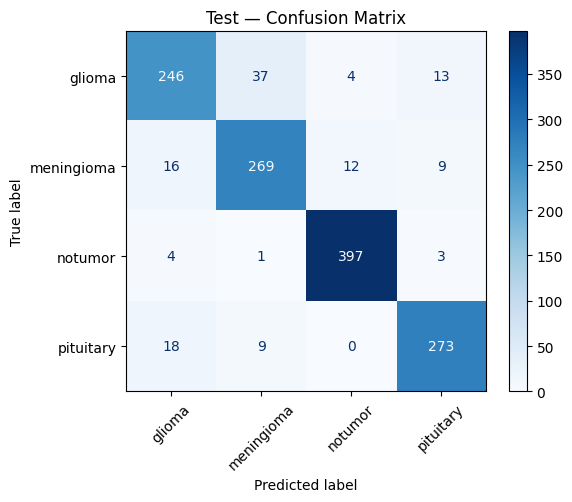

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def show_confusion(y, y_pred, CLASSES, title_prefix="Test", save_prefix=None, MAKE_PLOTS=True):
    all_labels = list(range(len(CLASSES)))
    cm = confusion_matrix(y, y_pred, labels=all_labels)

    fig, ax = plt.subplots(figsize=(6, 5))

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=CLASSES)

    disp.plot(ax=ax,
              cmap="Blues",
              colorbar=True,
              xticks_rotation=45)

    ax.set_title(f"{title_prefix} — Confusion Matrix")
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    plt.tight_layout()

    if save_prefix is not None:
        fig.savefig(f"{save_prefix}_confusion.png", dpi=160)

    if MAKE_PLOTS:
        plt.show()
    else:
        plt.close(fig)

show_confusion(y_true, y_pred, classes, title_prefix="Test", save_prefix="/content/test")
